<h1 align="center">研究生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习 M502019B</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">循环神经网络实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">25120323</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">授课老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">原继东</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2025年8月27日</span></div>
</div>

In [1]:
import os
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch import nn
from torchvision import datasets, transforms
from PIL import Image
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import collections
from typing import Literal, Union, Optional, List

print('Pytorch version:',torch.__version__)
if not torch.cuda.is_available():
    print('CUDA is_available:', torch.cuda.is_available())
else:
    print('CUDA version:', torch.version.cuda)
    print('CUDA device count:', torch.cuda.device_count())
    print('CUDA device name:', torch.cuda.get_device_name())
    print('CUDA device capability:', torch.cuda.get_device_capability())
    print('CUDA device memory:', f'{torch.cuda.get_device_properties(0).total_memory/1024/1024/1024:.2f}', 'GB')
print('CPU count:', cpu_count())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cpu_count = cpu_count()

Pytorch version: 2.7.1+cu118
CUDA version: 11.8
CUDA device count: 1
CUDA device name: NVIDIA TITAN Xp
CUDA device capability: (6, 1)
CUDA device memory: 11.90 GB
CPU count: 8


# 1. 

**手动实现循环神经网络RNN，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）**

In [2]:
torch.cuda.empty_cache()

构建数据集。

In [3]:
class TrafficDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.Tensor(inputs)
        # print(self.inputs.shape)
        self.targets = torch.Tensor(targets).unsqueeze(1)
        # print(self.targets.shape)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

    def __len__(self):
        return self.targets.shape[0]


def make_traffic_datasets(
    file_path: str, sensor: int = 10, target: int = 0, 
    train_por = 0.6, test_por = 0.2, window_size = 32, label_col = 0
):
    raw_data = np.load(file_path)['data']
    scaled_data = raw_data * np.array([1.0e-3, 1.0, 1.0e-2])
    sensor_data = scaled_data[:, sensor, :]

    window_inputs = np.stack([
        sensor_data[i : i + window_size] 
        for i in range(len(sensor_data) - window_size - 1)
    ], axis=0)
    labels = sensor_data[window_size:, label_col]

    shuffle_idx = np.arange(len(window_inputs))
    np.random.shuffle(shuffle_idx)
    window_inputs = window_inputs[shuffle_idx]
    labels = labels[shuffle_idx]

    len_train = int(len(labels) * train_por)
    len_test = int(len(labels) * test_por)
    len_valid = len(labels) - len_train - len_test

    train_dataset = TrafficDataset(inputs=window_inputs[:len_train, :], targets=labels[:len_train])
    valid_dataset = TrafficDataset(inputs=window_inputs[len_train:len_train+len_valid, :], targets=labels[len_train:len_train+len_valid])
    test_dataset = TrafficDataset(inputs=window_inputs[len_train+len_valid:, :], targets=labels[len_train+len_valid:])

    return train_dataset, valid_dataset, test_dataset


train_dataset, valid_dataset, test_dataset = make_traffic_datasets('./dataset/traffic-flow/raw/PEMS04.npz')
x, y = train_dataset[0]
print(f"训练集第1个样本输入：{x}")
print(f"训练集第1个样本标签：{y}")

训练集第1个样本输入：tensor([[0.4480, 0.1673, 0.3450],
        [0.5020, 0.1792, 0.3330],
        [0.5060, 0.1808, 0.3340],
        [0.4760, 0.1613, 0.3400],
        [0.4710, 0.1740, 0.3460],
        [0.4880, 0.1926, 0.3310],
        [0.4550, 0.2177, 0.3180],
        [0.4830, 0.1996, 0.3140],
        [0.4730, 0.1897, 0.3230],
        [0.4600, 0.1704, 0.3240],
        [0.5380, 0.1502, 0.3600],
        [0.5450, 0.1470, 0.3810],
        [0.4950, 0.1628, 0.3670],
        [0.4600, 0.1744, 0.3450],
        [0.4730, 0.1739, 0.3470],
        [0.4780, 0.1833, 0.3320],
        [0.4490, 0.1705, 0.3360],
        [0.5150, 0.1865, 0.3330],
        [0.4570, 0.1795, 0.3280],
        [0.5160, 0.1755, 0.3410],
        [0.4870, 0.1775, 0.3370],
        [0.4340, 0.1677, 0.3280],
        [0.4820, 0.1656, 0.3320],
        [0.5080, 0.1626, 0.3420],
        [0.4810, 0.1546, 0.3630],
        [0.5070, 0.1399, 0.3870],
        [0.5200, 0.1369, 0.3980],
        [0.4300, 0.0868, 0.4370],
        [0.5030, 0.0869, 0.5010],
   

构建序列回归任务的Trainer。

In [4]:
class Trainer():
    def __init__(
        self,
        model,
        train_dataset: Union[Dataset, DataLoader],
        eval_dataset: Union[Dataset, DataLoader],
        learning_rate: float,
        num_epochs: int,
        batch_size: int,
        weight_decay: float = 0.0,
        adam_beta1: float = 0.9,
        adam_beta2: float = 0.999,
        test_dataset: Union[Dataset, DataLoader] = None,
        plot: bool = True, 
        print_test_result: bool = True,
        logging_steps: int = 1,
        eval_steps: int = 1,
        print_log_epochs: int = 1,
        print_eval: bool = True
    ):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.plot = plot
        self.print_test_result = print_test_result
        self.logging_steps = logging_steps
        self.eval_steps = eval_steps
        self.print_log_epochs = print_log_epochs
        self.print_eval = print_eval
        
        if isinstance(train_dataset, Dataset):
            self.train_dataloader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                num_workers=cpu_count-1, pin_memory=True
            )
        else:
            self.train_dataloader = train_dataset
        if isinstance(eval_dataset, Dataset):
            self.eval_dataloader = DataLoader(
                dataset=eval_dataset, batch_size=batch_size, shuffle=True, 
                num_workers=cpu_count-1, pin_memory=True
            )
        else:
            self.eval_dataloader = eval_dataset
        if isinstance(test_dataset, Dataset):
            self.test_dataloader = DataLoader(
                dataset=test_dataset, batch_size=batch_size, shuffle=True, 
                num_workers=cpu_count-1, pin_memory=True
            )
        else:
            self.test_dataloader = test_dataset

        self.total_train_steps = self.num_epochs * len(self.train_dataloader)

        self.optimizer = torch.optim.AdamW(
            model.parameters(), lr=learning_rate, 
            weight_decay=weight_decay, betas=(adam_beta1, adam_beta2)
        )
        self.criterion = nn.MSELoss()

    def train(self):
        train_loss_curve = []
        eval_loss_curve = []
        eval_error_curve = []
        step = 0
        with tqdm(total=self.total_train_steps) as pbar:
            for epoch in range(self.num_epochs):
                total_train_loss = 0
                for x, targets in self.train_dataloader:
                    x = x.to(device=device, dtype=torch.float32)
                    targets = targets.to(device=device, dtype=torch.float32)

                    self.optimizer.zero_grad()
                    output = self.model(x)
                    loss = self.criterion(output, targets)
                    total_train_loss += loss.item()
                    if (step + 1) % self.logging_steps == 0:
                        train_loss_curve.append((step + 1, loss.item()))
            
                    loss.backward()
                    self.optimizer.step()
                    step += 1
                    pbar.update(1)

                    if self.eval_steps > 0 and (step + 1) % self.eval_steps == 0:
                        avg_eval_loss, avg_eval_error = self.eval()
                        eval_loss_curve.append((step + 1, avg_eval_loss))
                        eval_error_curve.append((step + 1, avg_eval_error))
                        eval_info = {
                            'Epoch': f'{(step + 1) / len(self.train_dataloader):.1f}/{self.num_epochs}',
                            'Total Valid Loss': f'{avg_eval_loss:.2f}',
                            'Avg Valid Error': f'{avg_eval_error:.2%}'
                        }
                        if self.print_eval:
                            print(eval_info)
                if self.print_log_epochs > 0 and (epoch + 1) % self.print_log_epochs == 0:
                    log_info = {
                        'Epoch': f'{(step + 1) / len(self.train_dataloader):.1f}/{self.num_epochs}',
                        'Total Train Loss': f'{total_train_loss:.2f}'
                    }
                    print(log_info)

        return_info = {}
        if self.test_dataloader:
            test_error = self.test()
            if self.print_test_result:
                print('Avg Test Error:', f'{test_error:.2%}')
            return_info['test_error'] = test_error
        if self.plot:
            self.plot_results(train_loss_curve, eval_loss_curve, eval_error_curve)
        return_info['curves'] = {
            'train_loss_curve': train_loss_curve,
            'eval_loss_curve': eval_loss_curve,
            'eval_error_curve': eval_error_curve
        }
        return return_info

    def eval(self):
        total_eval_loss = 0
        total_eval_error = 0
        total_eval_samples = 0
        with torch.inference_mode():
            for x, targets in self.eval_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.float32)
                output = self.model(x)
                loss = self.criterion(output, targets)
                total_eval_loss += loss.item()
                total_eval_error += torch.square(output - targets).sum().item()
                total_eval_samples += targets.numel()
        avg_eval_loss = total_eval_loss / len(self.eval_dataloader)
        avg_eval_error = total_eval_error / total_eval_samples
        return avg_eval_loss, avg_eval_error

    def test(self):
        total_test_error = 0
        total_test_samples = 0
        with torch.inference_mode():
            for x, targets in self.test_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.float32)
                output = self.model(x)
                total_test_error += torch.square(output - targets).sum().item()
                total_test_samples += targets.numel()
        avg_test_error = total_test_error / total_test_samples
        return avg_test_error
        
    def plot_results(self, train_loss_curve, eval_loss_curve, eval_error_curve):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        train_log_steps, train_losses = zip(*train_loss_curve)
        axes[0].plot(train_log_steps, train_losses, label='Training Loss', color='blue')
        eval_log_steps, eval_losses = zip(*eval_loss_curve)
        axes[0].plot(eval_log_steps, eval_losses, label='Validation Loss', color='orange')
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss Curve')
        axes[0].legend()
        axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

        eval_log_steps, eval_error = zip(*eval_error_curve)
        axes[1].plot(eval_log_steps, eval_error, label='Validation Error', color='red', marker='o')
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('Error')
        axes[1].set_title('Validation Error Curve')
        axes[1].legend()
        axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
        plt.tight_layout()
        plt.show()

构建模型。

In [5]:
class My_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            h = self.tanh(
                torch.matmul(x[:, i, :], self.w_h) + 
                torch.matmul(h, self.u_h) + self.b_h
            )  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        return torch.stack(y_list, dim=1), h
        

class Model_1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_1, self).__init__()
        self.rnn = My_RNN(input_size, hidden_size, hidden_size).to(device)
        self.relu = nn.LeakyReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        out = self.fc(self.relu(x[:, -1, :]))
        return out

训练。

  0%|          | 0/4000 [00:00<?, ?it/s]

{'Epoch': '12.5/100', 'Total Valid Loss': '0.01', 'Avg Valid Error': '0.97%'}
{'Epoch': '25.0/100', 'Total Valid Loss': '0.01', 'Avg Valid Error': '0.53%'}
{'Epoch': '37.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.36%'}
{'Epoch': '50.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.32%'}
{'Epoch': '62.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.30%'}
{'Epoch': '75.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.28%'}
{'Epoch': '87.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.27%'}
{'Epoch': '100.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.26%'}
Avg Test Error: 0.29%


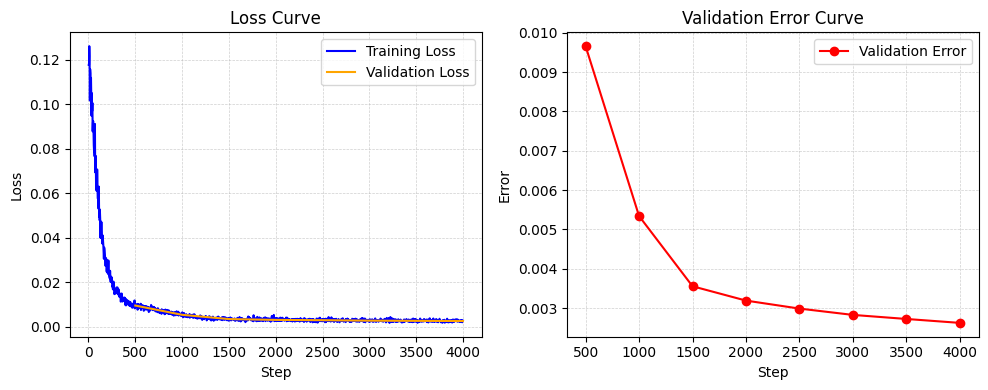

In [6]:
training_args = {
    'train_dataset': train_dataset,
    'eval_dataset': valid_dataset,
    'test_dataset': test_dataset,
    'learning_rate': 1.0e-6,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.0,
    'logging_steps': 3,
    'eval_steps': 500,
    'print_log_epochs': 0
}

model = Model_1(input_size=3, hidden_size=512, output_size=1).to(device)
trainer = Trainer(model=model, **training_args)
_ = trainer.train()

模型能够正常收敛。最终测试集上，预测值与真实值的误差不超过$0.5\%$。

# 2. 

**使用torch.nn.rnn实现循环神经网络，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）**

In [7]:
torch.cuda.empty_cache()

使用`torch.nn.RNN`替换手动实现的RNN网络模块构建新模型，并进行训练。

  0%|          | 0/4000 [00:00<?, ?it/s]

{'Epoch': '12.5/100', 'Total Valid Loss': '0.03', 'Avg Valid Error': '3.35%'}
{'Epoch': '25.0/100', 'Total Valid Loss': '0.02', 'Avg Valid Error': '2.16%'}
{'Epoch': '37.5/100', 'Total Valid Loss': '0.02', 'Avg Valid Error': '1.53%'}
{'Epoch': '50.0/100', 'Total Valid Loss': '0.01', 'Avg Valid Error': '0.52%'}
{'Epoch': '62.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.46%'}
{'Epoch': '75.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.42%'}
{'Epoch': '87.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.37%'}
{'Epoch': '100.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.33%'}
Avg Test Error: 0.36%


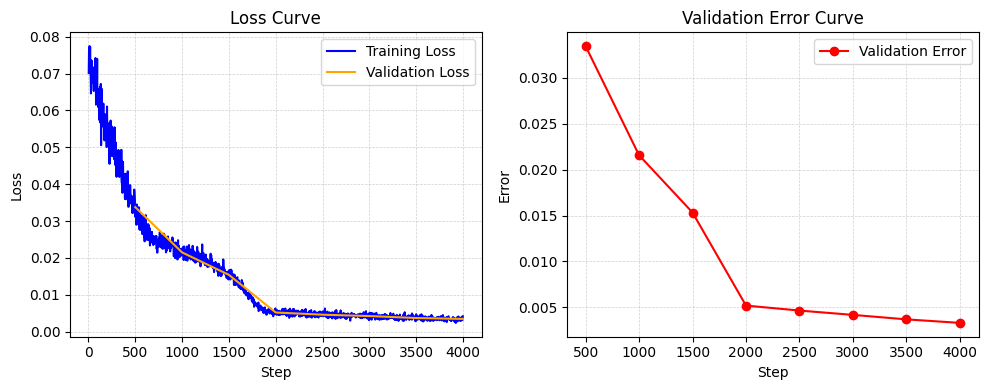

In [8]:
class Model_2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_2, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.relu = nn.LeakyReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        out = self.fc(self.relu(x[:, -1, :]))
        return out

training_args = {
    'train_dataset': train_dataset,
    'eval_dataset': valid_dataset,
    'test_dataset': test_dataset,
    'learning_rate': 1.0e-6,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.0,
    'logging_steps': 3,
    'eval_steps': 500,
    'print_log_epochs': 0
}

model = Model_2(input_size=3, hidden_size=512, output_size=1).to(device)
trainer = Trainer(model=model, **training_args)
_ = trainer.train()

最终模型效果相当，最终测试集上，`torch.nn.RNN`实现的模型，预测值与真实值的误差不超过$0.5\%$。

# 3.

**不同超参数的对比分析（包括hidden_size、batchsize、lr等）选其中至少1-2个进行分析**

In [9]:
torch.cuda.empty_cache()

选择`hidden_size`进行分析。

模型1（隐藏维度=128）开始训练：


  0%|          | 0/4000 [00:00<?, ?it/s]

Avg Test Error: 2.14%
模型2（隐藏维度=256）开始训练：


  0%|          | 0/4000 [00:00<?, ?it/s]

Avg Test Error: 0.47%
模型3（隐藏维度=512）开始训练：


  0%|          | 0/4000 [00:00<?, ?it/s]

Avg Test Error: 0.42%
模型4（隐藏维度=1024）开始训练：


  0%|          | 0/4000 [00:00<?, ?it/s]

Avg Test Error: 0.32%


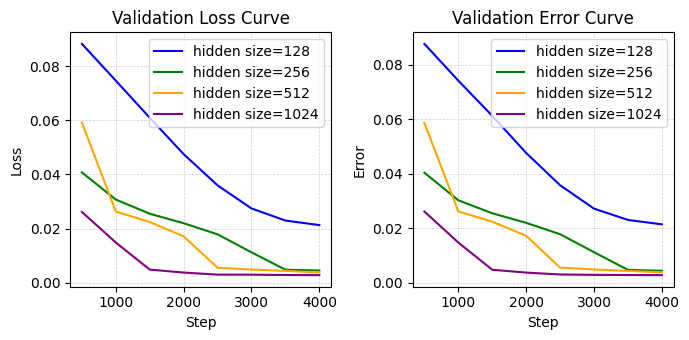

In [10]:
hidden_sizes = [128, 256, 512, 1024]
plot_colors = ['blue', 'green', 'orange', 'purple']

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss Curve')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Error')
axes[1].set_title('Validation Error Curve')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

training_args = {
    'train_dataset': train_dataset,
    'eval_dataset': valid_dataset,
    'test_dataset': test_dataset,
    'learning_rate': 1.0e-6,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.0,
    'logging_steps': 3,
    'eval_steps': 500,
    'plot': False,
    'print_log_epochs': 0,
    'print_eval': False
}

for index, hidden_size in enumerate(hidden_sizes):
    model = Model_2(input_size=3, hidden_size=hidden_size, output_size=1).to(device)
    
    print(f"模型{index + 1}（隐藏维度={hidden_size}）开始训练：")
    trainer = Trainer(model=model, **training_args)
    curves = trainer.train()['curves']

    eval_log_steps, eval_losses = zip(*curves['eval_loss_curve'])
    axes[0].plot(
        eval_log_steps, eval_losses,
        label=f"hidden size={hidden_size}", color=plot_colors[index]
    )
    eval_log_steps, eval_errors = zip(*curves['eval_error_curve'])
    axes[1].plot(
        eval_log_steps, eval_errors, 
        label=f"hidden size={hidden_size}", color=plot_colors[index]
    )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

从收敛过程和测试集结果来看，hidden_size越大，收敛越快，测试结果更优。

# 3.

**使用PyTorch实现LSTM和GRU并在至少一个数据集进行试验分析**

## 3.1. 实现LSTM

In [11]:
torch.cuda.empty_cache()

In [12]:
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell = \
                self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (
                self.sigmoid(g) for g in (forget_gate, input_gate, output_gate)
            )
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(h)
        return torch.stack(y_list, dim=1), (h, c)

训练。

  0%|          | 0/4000 [00:00<?, ?it/s]

{'Epoch': '12.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.39%'}
{'Epoch': '25.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.27%'}
{'Epoch': '37.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.26%'}
{'Epoch': '50.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.25%'}
{'Epoch': '62.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.24%'}
{'Epoch': '75.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.24%'}
{'Epoch': '87.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.23%'}
{'Epoch': '100.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.23%'}
Avg Test Error: 0.25%


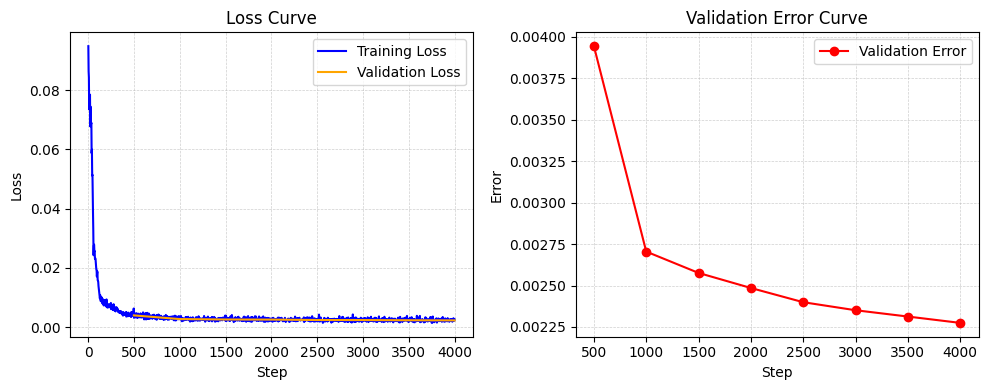

In [13]:
class Model_3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_3, self).__init__()
        self.rnn = My_LSTM(input_size=input_size, hidden_size=hidden_size)
        self.relu = nn.LeakyReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        out = self.fc(self.relu(x[:, -1, :]))
        return out


training_args = {
    'train_dataset': train_dataset,
    'eval_dataset': valid_dataset,
    'test_dataset': test_dataset,
    'learning_rate': 5.0e-5,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.0,
    'logging_steps': 3,
    'eval_steps': 500,
    'print_log_epochs': 0
}

model = Model_3(input_size=3, hidden_size=512, output_size=1).to(device)
trainer = Trainer(model=model, **training_args)
_ = trainer.train()

模型能正常收敛，且最终测试效果比普通RNN要好。

## 3.2. 实现GRU

In [14]:
torch.cuda.empty_cache()

In [15]:
class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 2)
        self.hidden_transform = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
            
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(h)
        return torch.stack(y_list, dim=1), h

  0%|          | 0/4000 [00:00<?, ?it/s]

{'Epoch': '12.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.32%'}
{'Epoch': '25.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.25%'}
{'Epoch': '37.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.24%'}
{'Epoch': '50.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.24%'}
{'Epoch': '62.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.23%'}
{'Epoch': '75.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.22%'}
{'Epoch': '87.5/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.22%'}
{'Epoch': '100.0/100', 'Total Valid Loss': '0.00', 'Avg Valid Error': '0.22%'}
Avg Test Error: 0.23%


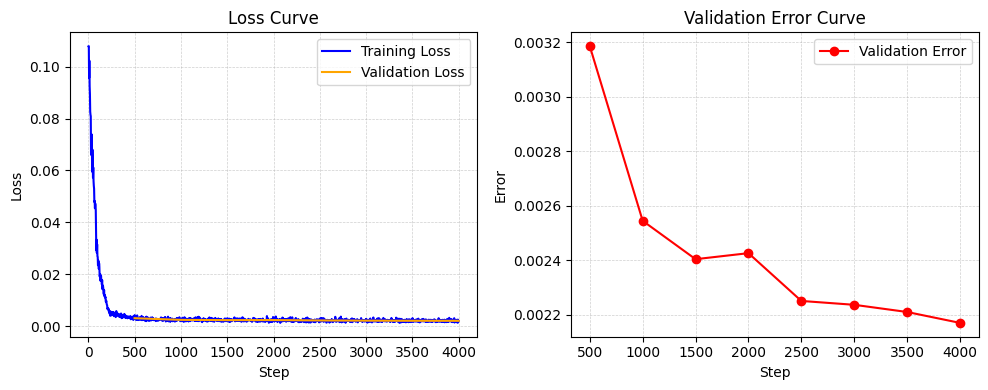

In [16]:
class Model_4(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_4, self).__init__()
        self.rnn = My_GRU(input_size=input_size, hidden_size=hidden_size)
        self.relu = nn.LeakyReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        out = self.fc(self.relu(x[:, -1, :]))
        return out


training_args = {
    'train_dataset': train_dataset,
    'eval_dataset': valid_dataset,
    'test_dataset': test_dataset,
    'learning_rate': 2.0e-5,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.0,
    'logging_steps': 3,
    'eval_steps': 500,
    'print_log_epochs': 0
}

model = Model_4(input_size=3, hidden_size=512, output_size=1).to(device)
trainer = Trainer(model=model, **training_args)
_ = trainer.train()

模型正常收敛，且测试集表现比LSTM更好。

# 4.

**设计实验，对比分析LSTM和GRU在相同数据集上的结果。**

In [17]:
torch.cuda.empty_cache()

In [18]:
class Model_5(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_5, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.relu = nn.LeakyReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        out = self.fc(self.relu(x[:, -1, :]))
        return out

class Model_6(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_6, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.relu = nn.LeakyReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        out = self.fc(self.relu(x[:, -1, :]))
        return out

模型1（模型架构=LSTM）开始训练：


  0%|          | 0/4000 [00:00<?, ?it/s]

Avg Test Error: 0.32%
模型2（模型架构=GRU）开始训练：


  0%|          | 0/4000 [00:00<?, ?it/s]

Avg Test Error: 0.26%


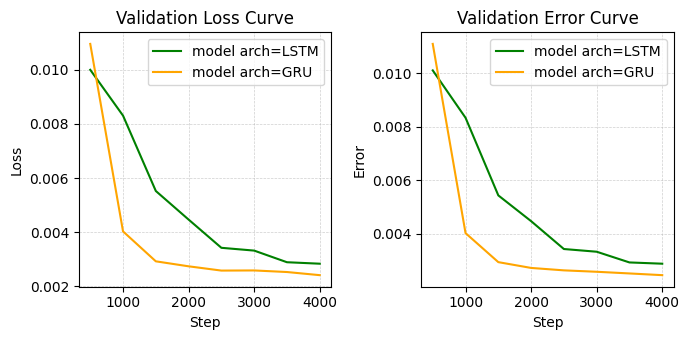

In [19]:
model_archs = ["LSTM", "GRU"]
plot_colors = ['green', 'orange']

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss Curve')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Error')
axes[1].set_title('Validation Error Curve')
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

training_args = {
    'train_dataset': train_dataset,
    'eval_dataset': valid_dataset,
    'test_dataset': test_dataset,
    'learning_rate': 1.0e-5,
    'num_epochs': 100,
    'batch_size': 256,
    'weight_decay': 0.0,
    'logging_steps': 3,
    'eval_steps': 500,
    'plot': False,
    'print_log_epochs': 0,
    'print_eval': False
}

for index, model_arch in enumerate(model_archs):
    model = (
        Model_5(input_size=3, hidden_size=512, output_size=1)
        if model_arch == "LSTM" else
        Model_6(input_size=3, hidden_size=512, output_size=1)
    ).to(device)
    
    print(f"模型{index + 1}（模型架构={model_arch}）开始训练：")
    trainer = Trainer(model=model, **training_args)
    curves = trainer.train()['curves']

    eval_log_steps, eval_losses = zip(*curves['eval_loss_curve'])
    axes[0].plot(
        eval_log_steps, eval_losses,
        label=f"model arch={model_arch}", color=plot_colors[index]
    )
    eval_log_steps, eval_errors = zip(*curves['eval_error_curve'])
    axes[1].plot(
        eval_log_steps, eval_errors, 
        label=f"model arch={model_arch}", color=plot_colors[index]
    )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

收敛曲线和测试集实验结果都表明，GRU比LSTM能力更优，且运行速度更快。